In [6]:
import numpy as np
import scipy as sc
import pandas as pd
import csv
import matplotlib.pyplot as plt

import SR_lib as sr

In [18]:
"""
FSK modulation of a bit stream.

Parameters:
- bits: array-like, list of 0s and 1s
- f0: frequency for bit 0 (Hz)
- f1: frequency for bit 1 (Hz)
- bit_duration: duration of each bit (seconds)
- fs: sampling frequency (samples/second)

Returns:
- t: time array
- signal: modulated FSK signal as numpy array
"""

def fsk_modulate(bits, f0 = 50, f1 = 150, bit_duration=0.1, fs=1e6):
    t = np.arange(0, bit_duration * len(bits), 1 / fs)
    signal = np.zeros_like(t)

    samples_per_bit = int(bit_duration * fs)
    
    for i, bit in enumerate(bits):
        f = f1 if bit else f0
        t_bit = t[i * samples_per_bit : (i + 1) * samples_per_bit]
        signal[i * samples_per_bit : (i + 1) * samples_per_bit] = np.sin(2 * np.pi * f * t_bit)
    
    return t, signal

"""
Goertzel algorithm to detect power at frequency f.
"""
def goertzel(samples, f, fs):

    N = len(samples)
    k = int(0.5 + (N * f) / fs)
    w = 2 * np.pi * k / N
    cosine = np.cos(w)
    sine = np.sin(w)
    coeff = 2 * cosine

    s_prev = 0
    s_prev2 = 0

    for sample in samples:
        s = sample + coeff * s_prev - s_prev2
        s_prev2 = s_prev
        s_prev = s

    power = s_prev2**2 + s_prev**2 - coeff * s_prev * s_prev2
    return power

"""
Demodulate FSK signal using Goertzel algorithm.

Parameters:
- signal: FSK modulated signal
- f0, f1: frequencies for 0 and 1
- bit_duration: duration of each bit (in seconds)
- fs: sampling frequency (in Hz)

Returns:
- recovered_bits: list of demodulated 0s and 1s
"""

def fsk_demodulate(signal, f0 = 50, f1 = 150, bit_duration=0.1, fs=1e6):

    samples_per_bit = int(bit_duration * fs)
    num_bits = len(signal) // samples_per_bit
    recovered_bits = []

    for i in range(num_bits):
        chunk = signal[i * samples_per_bit : (i + 1) * samples_per_bit]
        power_f0 = goertzel(chunk, f0, fs)
        power_f1 = goertzel(chunk, f1, fs)
        recovered_bits.append(1 if power_f1 > power_f0 else 0)

    return recovered_bits

"""
Apply a Schmitt trigger to an input signal.

Parameters:
    signal (array-like): The input signal (1D).
    high_thresh (float): Upper threshold for switching to high state (1).
    low_thresh (float): Lower threshold for switching to low state (0).
    initial_state (int): Starting state, either 0 or 1.

Returns:
    np.ndarray: Output signal after Schmitt trigger
"""
def schmitt_trigger(signal, high_thresh, low_thresh, high_val, low_val):

    output = np.zeros_like(signal)
    state = low_val

    for i, val in enumerate(signal):
        if state == low_val and val > high_thresh:
            state = high_val
        elif state == high_val and val < low_thresh:
            state = low_val
        output[i] = state

    return output


In [19]:
# FE double well system
tf = 255e-9
Dint = 0
alpha = -5.38e7
beta = 1.04e9
rho = 390

# fsk parameters
f0 = 50
f1 = 150
bit_duration=0.1
fs=1e6

In [20]:
hi = [0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1]
hi_bits = np.repeat(hi, 100)

#modulate 
t, fsk_sig = fsk_modulate(hi, f0, f1, bit_duration, fs)

# attenuation of the signa
att = 0.5
fsk_sig_att = fsk_sig*att

# adding noise to modulated signal
sd_ch = 1
fsk_sig_ch_noise = fsk_sig_att + np.random.normal(0, sd_ch, len(t))

# extra noise added to the system
sd_sys = 2.4
sys_noise = sr.gen_noise(t, sd_sys, 1e5)
fsk_sig_noise = fsk_sig_ch_noise + np.random.normal(0, sd_sys, len(t))

# double well system (to improve snr)
fsk_sr = sr.TDGL(t, 0.15, fsk_sig_noise/tf, Dint, alpha, beta, rho) #solve TDGL equation

# passing through a schmitt trigger
fsk_sch_trg = schmitt_trigger(fsk_sr, 0.15, -0.15, 0.2, -0.2)

# # doing ens avg
# ens = 1 # suppose there are 10 detectors
# fsk_sr_ens = 0
# for e in range(ens):
#     fsk_sr_ens += np.array(sr.TDGL(t, 0.15, fsk_sig_noise/tf, Dint, alpha, beta, rho)) #solve TDGL equation

# fsk_sr_ensavg = fsk_sr_ens/ens

# demodulation
hi_dm = fsk_demodulate(fsk_sch_trg, f0, f1, bit_duration, fs)

print("modulated = ", hi)
print("demodulated = ", hi_dm)
if (hi_dm == hi):
    print("received!")
else:
    print("error!")


modulated =  [0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1]
demodulated =  [0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1]
received!


In [21]:
# calculating SNR of the input and output signal

freq_in, psd_input = sc.signal.periodogram (fsk_sig_ch_noise, fs)
freq_out, psd_output = sc.signal.periodogram (np.array(fsk_sch_trg), fs)

_, _, Snr_f0_in = sr.power_snr_noisefloor_iisc(freq_in, psd_input, f0, fs, delw = int(f0/10), delw_noise = int(f0/2))
_, _, Snr_f1_in = sr.power_snr_noisefloor_iisc(freq_in, psd_input, f1, fs, delw = int(f1/10), delw_noise = int(f1/2))

_, _, Snr_f0_out = sr.power_snr_noisefloor_iisc(freq_out, psd_output, f0, fs, delw = int(f0/10), delw_noise = int(f0/2))
_, _, Snr_f1_out = sr.power_snr_noisefloor_iisc(freq_out, psd_output, f1, fs, delw = int(f1/10), delw_noise = int(f1/2))

print(f"Input SNR {f0} Hz:", 10*np.log10(Snr_f0_in), "dB")
print(f"Input SNR {f1} Hz:", 10*np.log10(Snr_f1_in), "dB")

print(f"Output SNR {f0} Hz:", 10*np.log10(Snr_f0_out), "dB")
print(f"Output SNR {f1} Hz:", 10*np.log10(Snr_f1_out), "dB")


Input SNR 50 Hz: 8.90591263531512 dB
Input SNR 150 Hz: 11.734068766187251 dB
Output SNR 50 Hz: 4.931692774424341 dB
Output SNR 150 Hz: 3.577563232296706 dB


In [22]:
# # bit_duration = 0.1
# # num_bits = int(t[-1] // bit_duration)

# clr = ["red", "blue", "black", "green", "cyan"]

# plt.figure(figsize=(25,10))

# plt.subplot(4,1,1)
# plt.plot(t, fsk_sig_noise, c = clr[2], linewidth = 0.1, label = "signal + channel noise + added noise")
# plt.plot(t, fsk_sig_ch_noise, c = clr[1], linewidth = 0.1, label = "signal + channel noise")
# plt.plot(t, fsk_sig_att, c = clr[0], linewidth = 3, label = "attenuated signal")

# for i, bit in enumerate(hi):
#     bit_center = (i + 0.5) * bit_duration
#     plt.axvline(x=i * bit_duration, color='gray', linestyle='--', linewidth=1)
#     plt.text(bit_center, 1.1, str(bit), ha='center', va='bottom', fontsize=10, color='yellow')
# plt.xlim([t[0], t[-1]])
# plt.ylim([-15, 15])
# plt.legend(loc="upper right")            

# plt.subplot(4,1,2)
# # plt.plot(t, fsk_sr_ensavg, linewidth = 0.1)
# plt.plot(t, fsk_sr, c = clr[3], linewidth = 0.1, label = "output from SR detector")
# plt.plot(t, fsk_sch_trg, c = clr[4], linewidth = 1, label = "output from schmitt trigger")

# for i, bit in enumerate(hi_dm):
#     plt.axvline(x=i * bit_duration, color='gray', linestyle='--', linewidth=1)
# plt.xlim([t[0], t[-1]])
# plt.ylim([-0.4, 0.4])
# plt.legend(loc="upper right")

# fro = int(fs*bit_duration*10)
# to = int(fs*bit_duration*12)

# plt.subplot(4,1,3)
# plt.plot(t[fro:to], fsk_sig_noise[fro:to], c = clr[2], linewidth = 0.1, label = "signal + channel noise + added noise")
# plt.plot(t[fro:to], fsk_sig_ch_noise[fro:to], c = clr[1], linewidth = 0.1, label = "signal + channel noise")
# plt.plot(t[fro:to], fsk_sig_att[fro:to], c = clr[0], linewidth = 3, label = "attenuated signal")
# plt.xlim([t[fro], t[to]])
# plt.ylim([-15, 15])
# plt.legend(loc="upper right")       

# plt.subplot(4,1,4)
# # plt.plot(t, fsk_sr_ensavg, linewidth = 0.1)
# plt.plot(t[fro:to], fsk_sr[fro:to], c = clr[3], linewidth = 0.1, label = "output from SR detector")
# plt.plot(t[fro:to], fsk_sch_trg[fro:to], c = clr[4], linewidth = 1, label = "output from schmitt trigger")

# plt.xlim([t[fro], t[to]])
# plt.ylim([-0.4, 0.4])
# plt.legend(loc="upper right")

# plt.show()

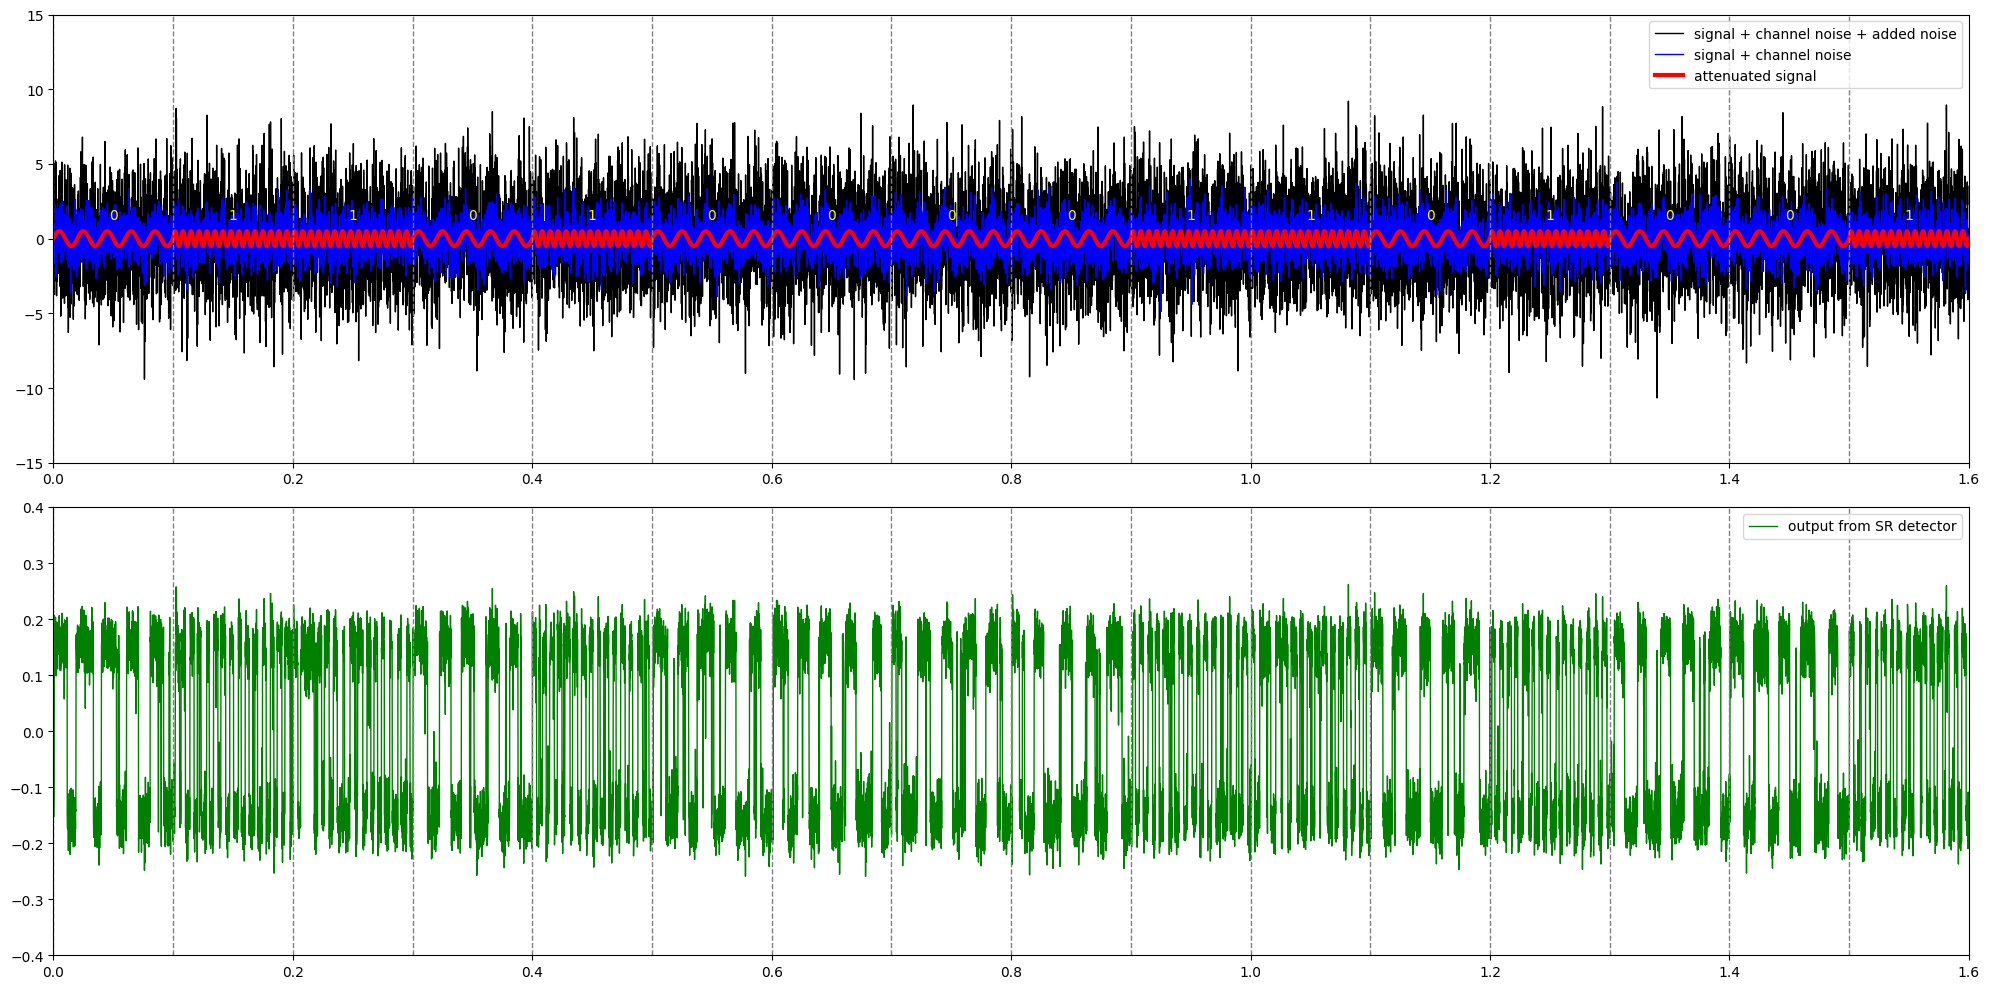

In [29]:
dsf = 100
# Set global font size
plt.rcParams.update({'font.size': 10})

# A4 size in inches: 8.27 x 11.69
# fig = plt.figure(figsize=(11.69, 8.27))  # Landscape A4

clr = ["red", "blue", "black", "green"]
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(t[::dsf], fsk_sig_noise[::dsf], c=clr[2], linewidth=1, label="signal + channel noise + added noise")
plt.plot(t[::dsf], fsk_sig_ch_noise[::dsf], c=clr[1], linewidth=1, label="signal + channel noise")
plt.plot(t[::dsf], fsk_sig_att[::dsf], c=clr[0], linewidth=3, label="attenuated signal")

for i, bit in enumerate(hi):
    bit_center = (i + 0.5) * bit_duration
    plt.axvline(x=i * bit_duration, color='gray', linestyle='--', linewidth=1)
    plt.text(bit_center, 1.1, str(bit), ha='center', va='bottom', fontsize=10, color='yellow')
plt.xlim([t[0], t[-1]])
plt.ylim([-15, 15])
plt.legend(loc="upper right")

plt.subplot(2,1,2)
plt.plot(t[::dsf], fsk_sr[::dsf], c=clr[3], linewidth=1, label="output from SR detector")
for i, bit in enumerate(hi_dm):
    plt.axvline(x=i * bit_duration, color='gray', linestyle='--', linewidth=1)
plt.xlim([t[::dsf][0], t[::dsf][-1]])
plt.ylim([-0.4, 0.4])
plt.legend(loc="upper right")

# Save to PDF
plt.tight_layout()
plt.savefig("fsk_plot.pdf")
plt.show()


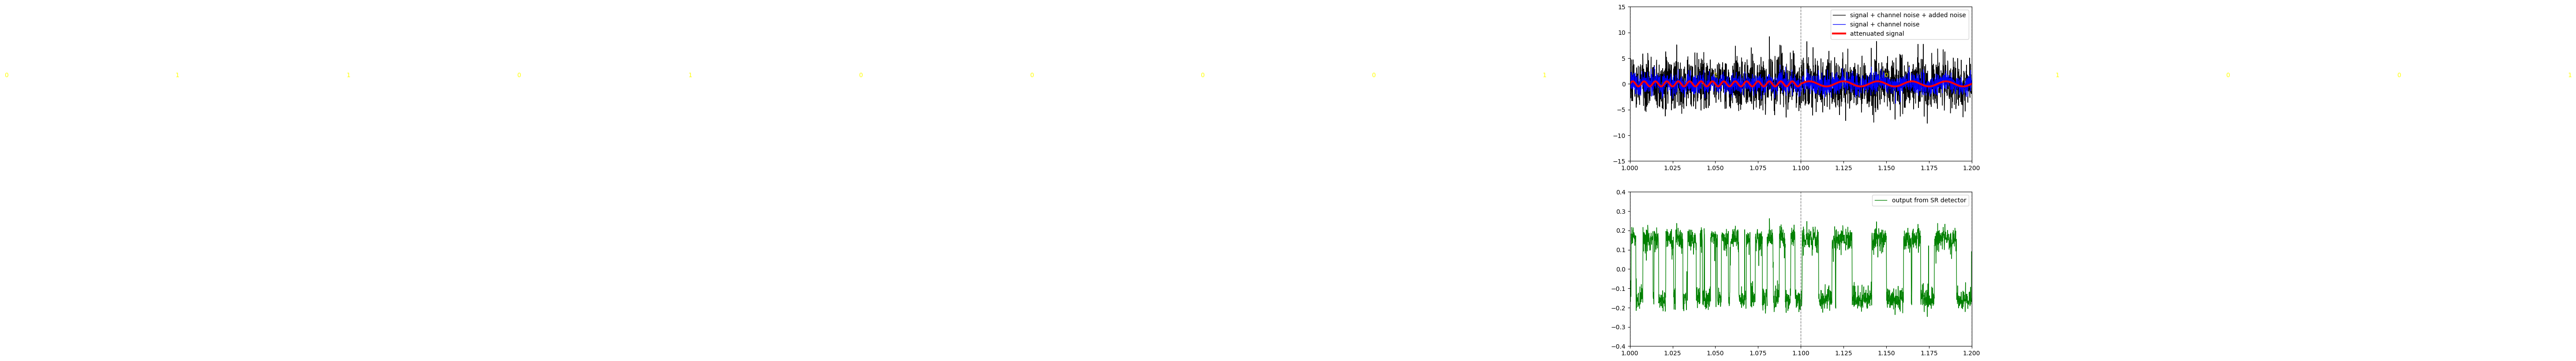

In [32]:

dsf = 100

# Set global font size
plt.rcParams.update({'font.size': 10})

# A4 size in inches: 8.27 x 11.69
# fig = plt.figure(figsize=(11.69, 8.27))  # Landscape A4
plt.figure(figsize=(10,10))
clr = ["red", "blue", "black", "green"]
fro = int(fs*bit_duration*10/dsf)
to = int(fs*bit_duration*12/dsf)
plt.subplot(2,1,1)
plt.plot(t[::dsf][fro:to], fsk_sig_noise[::dsf][fro:to], c=clr[2], linewidth=1, label="signal + channel noise + added noise")
plt.plot(t[::dsf][fro:to], fsk_sig_ch_noise[::dsf][fro:to], c=clr[1], linewidth=1, label="signal + channel noise")
plt.plot(t[::dsf][fro:to], fsk_sig_att[::dsf][fro:to], c=clr[0], linewidth=3, label="attenuated signal")

for i, bit in enumerate(hi):
    bit_center = (i + 0.5) * bit_duration
    plt.axvline(x=i * bit_duration, color='gray', linestyle='--', linewidth=1)
    plt.text(bit_center, 1.1, str(bit), ha='center', va='bottom', fontsize=10, color='yellow')
plt.xlim([t[::dsf][fro], t[::dsf][to]])
plt.ylim([-15, 15])
plt.legend(loc="upper right")

plt.subplot(2,1,2)
plt.plot(t[::dsf][fro:to], fsk_sr[::dsf][fro:to], c=clr[3], linewidth=1, label="output from SR detector")
for i, bit in enumerate(hi_dm):
    plt.axvline(x=i * bit_duration, color='gray', linestyle='--', linewidth=1)
plt.xlim([t[::dsf][fro], t[::dsf][to]])
plt.ylim([-0.4, 0.4])
plt.legend(loc="upper right")

# Save to PDF
# plt.tight_layout()
plt.savefig("fsk_plot_zoom.pdf")
plt.show()


### hardware data

In [11]:
fskdata = pd.read_excel('FSK_data.xlsx')
fsk_sig_noise = pd.read_csv('fsk_0_37hz_1_75hz_bit_rate_5_sd_1_2_input.csv')
time = np.array(fskdata.iloc[:,0].to_list())*1e-3
bit_stream = fskdata.iloc[:,1].to_list()
Vin = fskdata.iloc[:,2].to_list()
Vin_noise = fsk_sig_noise["30000"].to_list()
Pout = np.array(fskdata.iloc[:,3].to_list())*1e-2

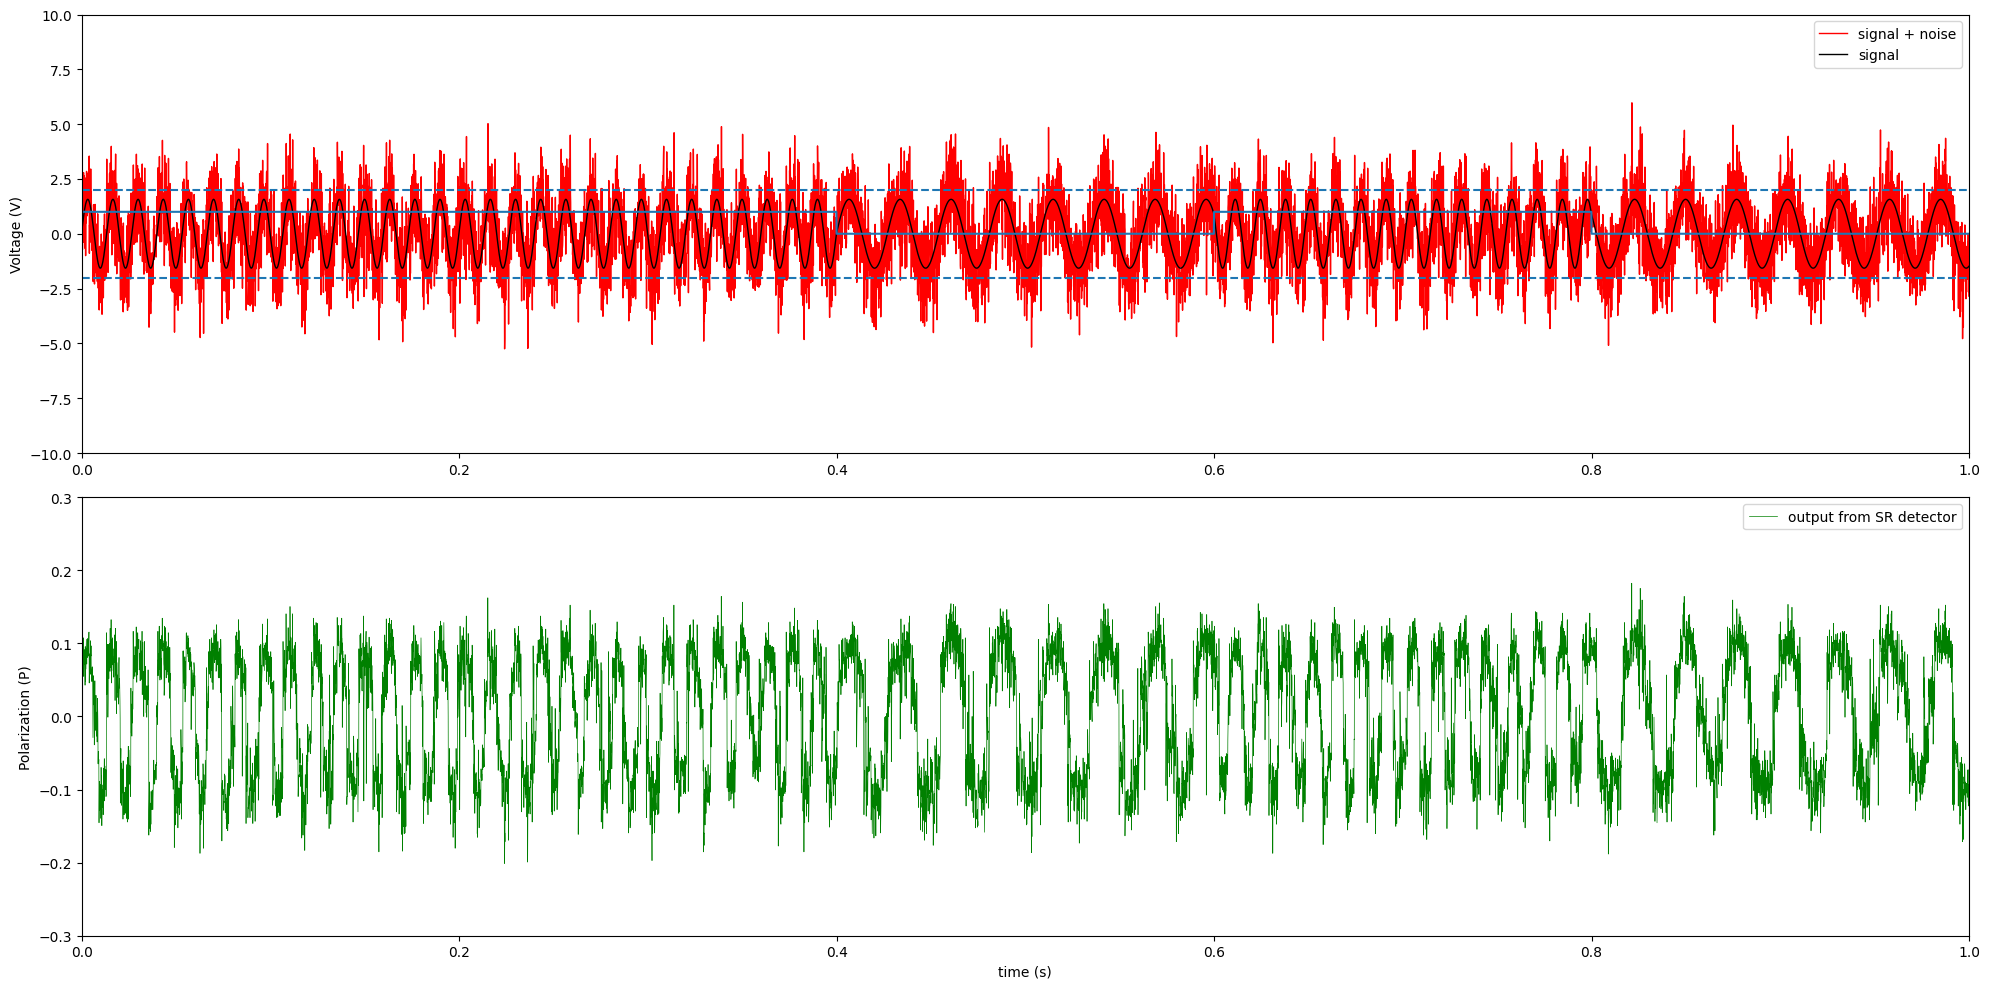

In [26]:
# Set global font size
plt.rcParams.update({'font.size': 10})

# A4 size in inches: 8.27 x 11.69
# fig = plt.figure(figsize=(11.69, 8.27))  # Landscape A4
fro = 0
to = 10000
Vc = 2
clr = ["red", "blue", "black", "green"]
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(time[fro:to], Vin_noise[fro:to], c=clr[0], linewidth=1, label="signal + noise")
plt.plot(time[fro:to], Vin[fro:to], c=clr[2], linewidth=1, label="signal")
plt.plot(time[fro:to], bit_stream[fro:to])
plt.axhline(y = Vc, linestyle = "--")
plt.axhline(y = -Vc, linestyle = "--")
plt.ylabel("Voltage (V)")
plt.xlim([time[fro], time[to]])
plt.ylim([-10, 10])
plt.legend(loc="upper right")

plt.subplot(2,1,2)
plt.plot(time[fro:to], Pout[fro:to], c=clr[3], linewidth=0.5, label="output from SR detector")
plt.xlim([time[fro], time[to]])
plt.ylim([-0.3, 0.3])
plt.ylabel("Polarization (P)")
plt.xlabel("time (s)")
plt.legend(loc="upper right")

# Save to PDF
plt.tight_layout()
plt.savefig("fsk_plot_iisc.pdf")
plt.show()
